Normal dataset from: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download

Covid dataset from: https://github.com/ieee8023/covid-chestxray-dataset/tree/master/images

In [1]:
#Imports do código
from os import listdir
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
len(tf.config.experimental.list_physical_devices('GPU'))

0

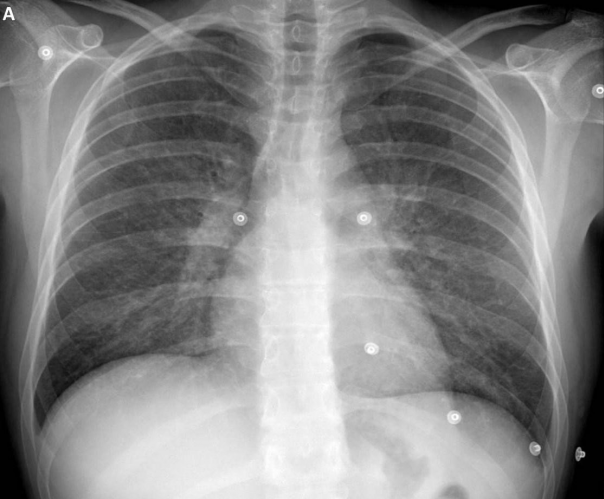

In [5]:
#Testando o shape para as imagens
im = Image.open('../data/covid-19/000001-1.png')
im

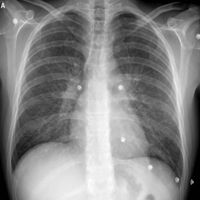

In [6]:
im.resize((200,200))

In [7]:
#Criando os arrays para os labels e as imagens, e preenchendo-os
images = []
labels = []
for file in listdir('../data/covid-19'):
    image = Image.open('../data/covid-19/'+file)
    image = image.convert('RGB')
    image = image.resize((200,200))
    images.append(np.asarray(image))
    labels.append(1)

for file in listdir('../data/normal'):
    image = Image.open('../data/normal/'+file)
    image = image.convert('RGB')
    image = image.resize((200,200))
    images.append(np.asarray(image))
    labels.append(0)

In [8]:
#Separando o conjunto em treino e teste
(train_x, test_x, train_y, test_y) = train_test_split(images, labels, test_size=0.2, train_size=0.8, random_state=42, shuffle=True)

In [9]:
#Normalizando as imagens, e passando os labels para np array

train_x = np.array(train_x) /255
train_y = np.array(train_y)

In [10]:
test_x = np.array(test_x) /255
test_y = np.array(test_y)

In [12]:
#Verificando o tamanho dos conjuntos
print(len(train_x))
print(len(train_y))
print(len(test_x))
print(len(test_y))

2004
2004
501
501


In [11]:
#Criando o Modelo de CNN que será utilizado
def get_Model(optimizer):
  model = Sequential()
  model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(200,200,3)))
  model.add(MaxPooling2D())

  model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(200,200,3)))
  model.add(MaxPooling2D())

  model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(200,200,3)))
  model.add(MaxPooling2D())

  model.add(Flatten())

  model.add(Dense(200, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

  return model

 # Como teste(Primeiro experimento), iremos usar apenas uma Rede, e gerar metricas e gráficoas a partir dela.

In [14]:
#Iremos utilizar um modelo que vai receber como parâmetro o otimizador, que nesse caso será RMSprop, além de reduzir o tamanho do treino.
model_teste = get_Model('RMSprop')

In [24]:
reduced_data_train_x = train_x[:200]
reduced_data_train_y = train_y[:200]

In [16]:
modelTeste_history = model_teste.fit(reduced_data_train_x, reduced_data_train_y, batch_size=50, epochs=3)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 3s 370ms/step - loss: 1.1214 - accuracy: 0.5100
Epoch 2/3
4/4 [==============================] - 1s 331ms/step - loss: 0.6357 - accuracy: 0.6400
Epoch 3/3
4/4 [==============================] - 1s 321ms/step - loss: 0.5848 - accuracy: 0.7000


In [17]:
#Acurácia e loss do teste

test_loss, test_acc = model_teste.evaluate(test_x, test_y,
                                   batch_size=128,
                                   verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Test loss: 0.5180341601371765
Test accuracy: 0.7205588817596436


Como observado, obtivemos o resultado de acurácia de 70% no conjunto de teste, e de 72% no conjunto de treino com o otimizador RMSprop. O intuito da utilização do grid search, é encontrar os melhores parâmetros para elevarmos o máximo possível a acurácia do nosso modelo.

In [15]:
modelTeste_history.history

{'loss': [0.5193422436714172, 0.5112618803977966, 0.42304256558418274],
 'accuracy': [0.8600000143051147, 0.7300000190734863, 0.8050000071525574]}

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'Epoch')

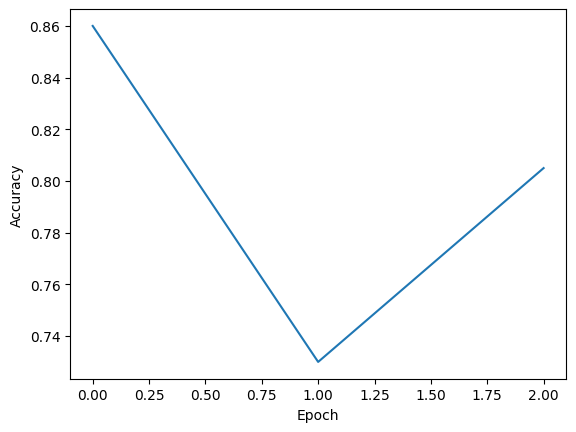

In [17]:
plt.plot(modelTeste_history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Gráfico de Acurácia por época

Text(0.5, 0, 'Epoch')

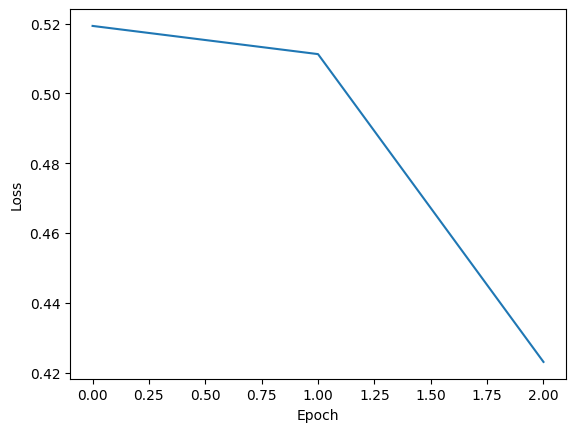

In [18]:
plt.plot(modelTeste_history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')

Gráfico de Loss por época

In [13]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [20]:
#Criando as predições para
pred = model_teste.predict(test_x)
pred = pred.ravel().tolist()
predictions = []
for x in pred:
  predictions.append(round(x))
test_predictions = test_y.tolist()

16/16 [==============================] - 1s 42ms/step


In [23]:
cf_matrix = confusion_matrix(test_predictions, predictions)

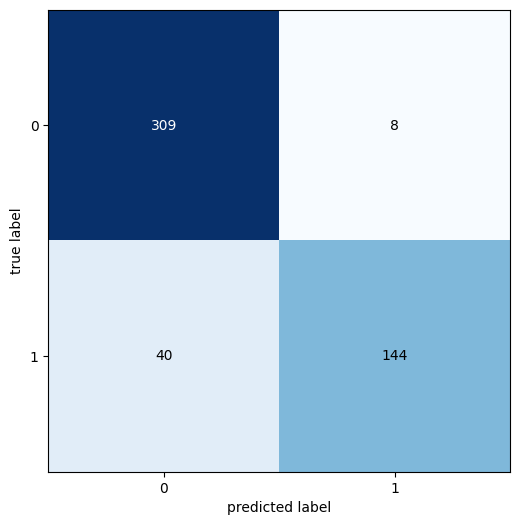

In [24]:
fig, ax = plot_confusion_matrix(conf_mat=cf_matrix, figsize=(6, 6))
plt.show()

In [14]:
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score

Métricas escolhidas

In [26]:
#Calculando as métricas:

print('Acurácia Balanceada: '+ str(100*(balanced_accuracy_score(test_predictions, predictions))))
print('\nF1 Score: '+ str(100*(f1_score(test_predictions, predictions, average='binary'))))
print('\nPrecision Score: '+ str(100*(precision_score(test_predictions, predictions, average='binary'))))
print('\nRecall Score: '+ str(100*(recall_score(test_predictions, predictions, average='binary'))))
print('\nEspecificidade: '+ str(100*(307/317))) # Verdadeiros negativos / Verdadeiros negativos+ Falsos positivos

Acurácia Balanceada: 87.86860512961185

F1 Score: 85.71428571428571

Precision Score: 94.73684210526315

Recall Score: 78.26086956521739

Especificidade: 96.84542586750788


Apesar dos resultados razoaveis, ainda podemos melhorar com a técnica que iremos utilizar.

# Experimento que deu errado, com otimizador Adagrad

In [27]:
model_teste_2 = get_Model('Adagrad')

In [28]:
modelTeste_history_2 = model_teste_2.fit(reduced_data_train_x, reduced_data_train_y, batch_size=50, epochs=5)

Epoch 1/5
4/4 [==============================] - 2s 364ms/step - loss: 0.7078 - accuracy: 0.3650
Epoch 2/5
4/4 [==============================] - 1s 358ms/step - loss: 0.6978 - accuracy: 0.3500
Epoch 3/5
4/4 [==============================] - 1s 315ms/step - loss: 0.6901 - accuracy: 0.6150
Epoch 4/5
4/4 [==============================] - 1s 312ms/step - loss: 0.6838 - accuracy: 0.6300
Epoch 5/5
4/4 [==============================] - 1s 311ms/step - loss: 0.6783 - accuracy: 0.6300


In [29]:
#Criando as predições para
pred_error = model_teste_2.predict(test_x)
pred_error = pred_error.ravel().tolist()

16/16 [==============================] - 1s 46ms/step


In [30]:
predictions_error = []
for x in pred_error:
  predictions_error.append(round(x))

In [31]:
test_predictions_error = test_y.tolist()

In [32]:
cf_matrix_error = confusion_matrix(test_predictions_error, predictions_error)

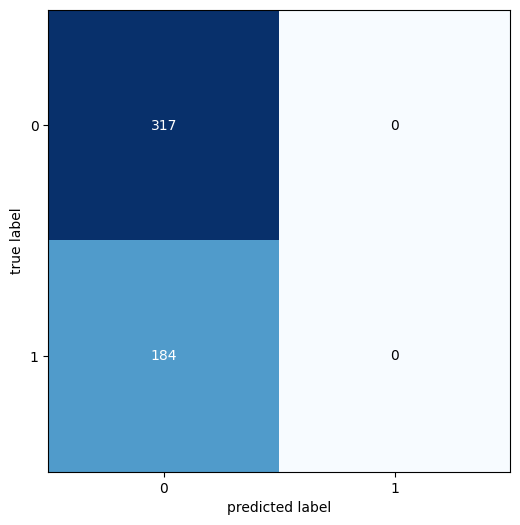

In [33]:
fig, ax = plot_confusion_matrix(conf_mat=cf_matrix_error, figsize=(6, 6))
plt.show()

Como pode ser observado, o otimizador não foi o correto para o problema, e predizeu todas as amostras como saudáveis.

 # O protocolo de validação utilizado, será o método do Grid Search e o Crossvalidation-3. Para isso, utilizaremos a função GridSearchCV do SKlearn. O Grid Search consiste na variação de hiper-parâmetros, para encontrar os melhores resultados.

In [38]:
#Definindo os hiperparâmetros para o Grid Search
optimizer = ['adam', 'SGD', 'Adamax']
batch_size = [334, 668]
epochs = [5, 10]

param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs)

In [39]:
param_grid

{'optimizer': ['adam', 'SGD', 'Adamax'],
 'batch_size': [334, 668],
 'epochs': [5, 10]}

In [40]:
#Parâmetros do GridSearchCV consistem em: estimator que é o modelo utilizado, param grid que são os hiper-parametros definidos, n_jobs = None para não utilizar a GPU(já que não é possível rodar em qualquer computador), e cv que é o crossvalidation-5.
Kmodel = KerasClassifier(build_fn=get_Model, verbose=1)
grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid, n_jobs=None, cv=3, scoring='accuracy')

C:\Users\Conrado\AppData\Local\Temp\ipykernel_22676\2375747579.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  Kmodel = KerasClassifier(build_fn=get_Model, verbose=1)


In [41]:
grid_results = grid.fit(reduced_data_train_x, reduced_data_train_y)

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6927 - accuracy: 0.4737
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 0.6992 - accuracy: 0.6241
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 0.6205 - accuracy: 0.6241
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 0.6073 - accuracy: 0.6692
Epoch 5/5
3/3 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6981 - accuracy: 0.3459
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 0.7455 - accuracy: 0.6316
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 0.6161 - accuracy: 0.6316
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 0.6354 - accuracy: 0.9098
Epoch 5/5
3/3 [==============================] - 0s 31ms/step
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6879 - accuracy: 0.6567
Epoch 2/5
1/1 [===============

In [42]:
# Sumarizando os resultados do Grid Search

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.834766 using {'batch_size': 334, 'epochs': 10, 'optimizer': 'adam'}
0.770767 (0.116604) with: {'batch_size': 334, 'epochs': 5, 'optimizer': 'adam'}
0.629956 (0.008681) with: {'batch_size': 334, 'epochs': 5, 'optimizer': 'SGD'}
0.688452 (0.223081) with: {'batch_size': 334, 'epochs': 5, 'optimizer': 'Adamax'}
0.834766 (0.054023) with: {'batch_size': 334, 'epochs': 10, 'optimizer': 'adam'}
0.634931 (0.015576) with: {'batch_size': 334, 'epochs': 10, 'optimizer': 'SGD'}
0.634931 (0.009701) with: {'batch_size': 334, 'epochs': 10, 'optimizer': 'Adamax'}
0.696216 (0.237979) with: {'batch_size': 668, 'epochs': 5, 'optimizer': 'adam'}
0.629956 (0.008681) with: {'batch_size': 668, 'epochs': 5, 'optimizer': 'SGD'}
0.820142 (0.041693) with: {'batch_size': 668, 'epochs': 5, 'optimizer': 'Adamax'}
0.799186 (0.115133) with: {'batch_size': 668, 'epochs': 10, 'optimizer': 'adam'}
0.629956 (0.008681) with: {'batch_size': 668, 'epochs': 10, 'optimizer': 'SGD'}
0.815543 (0.091016) with: {'batch_siz

Vamos utilizar os 3 melhores modelos do grid search e ver qual se sai melhor com a base completa

In [15]:
#Primeiro modelo
best_model = get_Model('adam')

In [16]:
best_model_history = best_model.fit(train_x, train_y, batch_size=334, epochs=10)

Epoch 1/10
6/6 [==============================] - 16s 2s/step - loss: 0.8027 - accuracy: 0.5499
Epoch 2/10
6/6 [==============================] - 13s 2s/step - loss: 0.5392 - accuracy: 0.6941
Epoch 3/10
6/6 [==============================] - 13s 2s/step - loss: 0.3146 - accuracy: 0.9132
Epoch 4/10
6/6 [==============================] - 12s 2s/step - loss: 0.1771 - accuracy: 0.9341
Epoch 5/10
6/6 [==============================] - 12s 2s/step - loss: 0.1179 - accuracy: 0.9581
Epoch 6/10
6/6 [==============================] - 13s 2s/step - loss: 0.0864 - accuracy: 0.9681
Epoch 7/10
6/6 [==============================] - 12s 2s/step - loss: 0.0904 - accuracy: 0.9666
Epoch 8/10
6/6 [==============================] - 12s 2s/step - loss: 0.0972 - accuracy: 0.9676
Epoch 9/10
6/6 [==============================] - 12s 2s/step - loss: 0.0720 - accuracy: 0.9736
Epoch 10/10
6/6 [==============================] - 12s 2s/step - loss: 0.0507 - accuracy: 0.9835


In [17]:
#Acurácia e loss do teste

test_loss, test_acc = best_model.evaluate(test_x, test_y, batch_size=334 ,verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Test loss: 0.048524726182222366
Test accuracy: 0.9860279560089111


In [18]:
#Criando as predições para
best_pred = best_model.predict(test_x)
best_pred = best_pred.ravel().tolist()
best_predictions = []
for x in best_pred:
  best_predictions.append(round(x))
test_predictions = test_y.tolist()

16/16 [==============================] - 1s 44ms/step


In [19]:
cf_matrix = confusion_matrix(test_predictions, best_predictions)

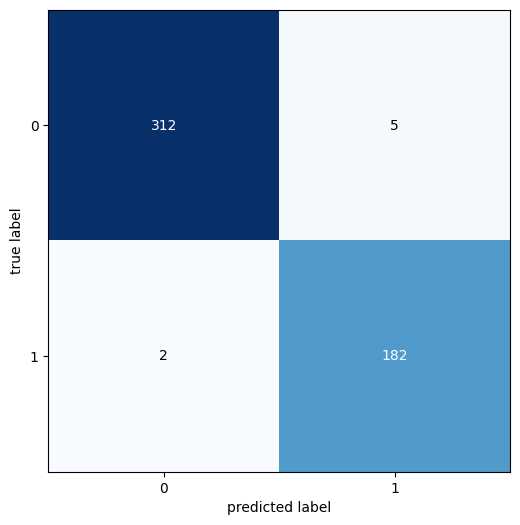

In [20]:
fig, ax = plot_confusion_matrix(conf_mat=cf_matrix, figsize=(6, 6))
plt.show()

Text(0.5, 0, 'Epoch')

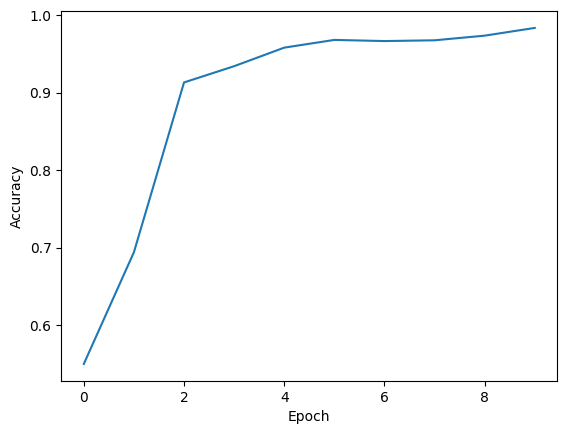

In [22]:
plt.plot(best_model_history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

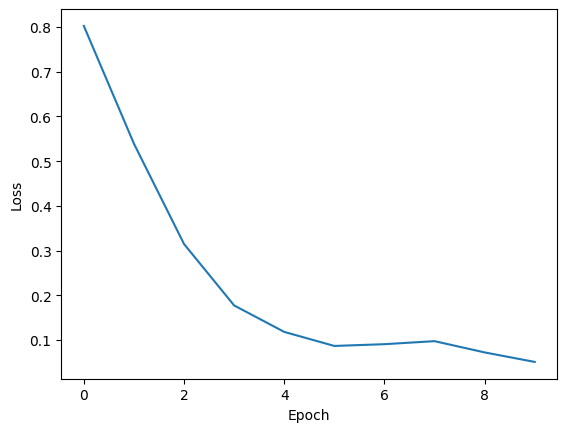

In [21]:
plt.plot(best_model_history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [24]:
#Calculando as métricas do melhor modelo encontrado pelo Grid Search:

print('Acurácia Balanceada: '+ str(100*(balanced_accuracy_score(test_predictions, best_predictions))))
print('\nF1 Score: '+ str(100*(f1_score(test_predictions, best_predictions, average='binary'))))
print('\nPrecision Score: '+ str(100*(precision_score(test_predictions, best_predictions, average='binary'))))
print('\nRecall Score: '+ str(100*(recall_score(test_predictions, best_predictions, average='binary'))))
print('\nEspecificidade: '+ str(100*(307/317))) # Verdadeiros negativos / Verdadeiros negativos+ Falsos positivos

Acurácia Balanceada: 98.6678782060074

F1 Score: 98.11320754716981

Precision Score: 97.32620320855615

Recall Score: 98.91304347826086

Especificidade: 96.84542586750788


In [25]:
#Segundo modelo
second_model = get_Model('Adamax')

In [26]:
second_model_history = second_model.fit(train_x, train_y, batch_size=668, epochs=5)

Epoch 1/5
3/3 [==============================] - 22s 5s/step - loss: 0.7419 - accuracy: 0.5818
Epoch 2/5
3/3 [==============================] - 13s 4s/step - loss: 0.6380 - accuracy: 0.5744
Epoch 3/5
3/3 [==============================] - 13s 5s/step - loss: 0.5320 - accuracy: 0.6382
Epoch 4/5
3/3 [==============================] - 13s 4s/step - loss: 0.4807 - accuracy: 0.7001
Epoch 5/5
3/3 [==============================] - 12s 4s/step - loss: 0.4052 - accuracy: 0.9326


In [30]:
#Acurácia e loss do teste

test_loss, test_acc = second_model.evaluate(test_x, test_y, batch_size=668 ,verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Test loss: 0.3509097397327423
Test accuracy: 0.9221556782722473


Como podemos ver, o primeiro modelo ainda se saiu melhor.

In [28]:
third_model = get_Model('Adamax')

In [29]:
third_model_history = third_model.fit(train_x, train_y, batch_size=668, epochs=10)

Epoch 1/10
3/3 [==============================] - 21s 5s/step - loss: 0.8787 - accuracy: 0.5374
Epoch 2/10
3/3 [==============================] - 13s 4s/step - loss: 0.5680 - accuracy: 0.6188
Epoch 3/10
3/3 [==============================] - 14s 5s/step - loss: 0.5056 - accuracy: 0.7241
Epoch 4/10
3/3 [==============================] - 14s 5s/step - loss: 0.4348 - accuracy: 0.9167
Epoch 5/10
3/3 [==============================] - 16s 5s/step - loss: 0.3806 - accuracy: 0.9157
Epoch 6/10
3/3 [==============================] - 15s 5s/step - loss: 0.3311 - accuracy: 0.9157
Epoch 7/10
3/3 [==============================] - 13s 4s/step - loss: 0.2736 - accuracy: 0.9276
Epoch 8/10
3/3 [==============================] - 13s 4s/step - loss: 0.2183 - accuracy: 0.9336
Epoch 9/10
3/3 [==============================] - 13s 5s/step - loss: 0.1735 - accuracy: 0.9446
Epoch 10/10
3/3 [==============================] - 13s 4s/step - loss: 0.1356 - accuracy: 0.9506


In [31]:
#Acurácia e loss do teste

test_loss, test_acc = third_model.evaluate(test_x, test_y, batch_size=668 ,verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Test loss: 0.11959429085254669
Test accuracy: 0.9640718698501587


Apesar de ser melhor que o segundo modelo, não bate o primeiro que obteve 98,6% de acurácia, portanto iremos salvar o modelo, para uso posterior.

In [32]:
import joblib

In [33]:
joblib.dump(best_model, 'COVID19_PREDICT.joblib')

INFO:tensorflow:Assets written to: ram://f923ba27-e24e-4793-be3c-e7f44bf1b2e8/assets


INFO:tensorflow:Assets written to: ram://f923ba27-e24e-4793-be3c-e7f44bf1b2e8/assets


['COVID19_PREDICT.joblib']